In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np

In [132]:
# 한글 폰트 경로 설정 (시스템에 설치된 한글 폰트 경로를 사용)
font_path = r"C:\Users\dlwng\OneDrive\바탕 화면\나눔고딕\NanumGothic.ttf"  # 예시 경로
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = font_prop.get_name()


In [133]:
# 데이터 불러오기
train = pd.read_csv(r"C:\Users\dlwng\OneDrive\바탕 화면\sas\TRAIN_DATA.csv", encoding='cp949')
test = pd.read_csv(r'C:\Users\dlwng\OneDrive\바탕 화면\sas\TEST_DATA.csv', encoding='cp949')

#ondo = pd.read_csv

In [134]:
df = train

# 데이터 전처리 + EDA

In [135]:
# 1. DIST_CD 분리
df['DIST_CD'] = df['DIST_CD'].astype(str)
df['SIDO_CD'] = df['DIST_CD'].str[:2]   # 시도코드
df['ADDR_CD'] = df['DIST_CD'].str[3:]   # 상세 주소 코드 (필요 시 참고)

In [136]:
# 2. SIDO 매핑 (지역 이름)
sido_code_map = {
    '11': '서울특별시', '26': '부산광역시', '27': '대구광역시', '28': '인천광역시',
    '29': '광주광역시', '30': '대전광역시', '31': '울산광역시', '36': '세종특별자치시',
    '41': '경기도', '42': '강원도', '43': '충청북도', '44': '충청남도',
    '45': '전라북도', '46': '전라남도', '47': '경상북도', '48': '경상남도',
    '49': '제주도', '50': '제주특별자치도', '51': '강원특별자치도', '52': '전북특별자치도'
}
df['SIDO_NM'] = df['SIDO_CD'].map(sido_code_map)

In [137]:
# 3. DATA_YM → datetime 변환
df['DATA_YM'] = pd.to_datetime(df['DATA_YM'].astype(str), format='%Y%m')

In [138]:
# 중복확인 
train.duplicated().sum()

754

In [139]:
train.shape

(26099, 23)

In [140]:
# 4. 중복 제거
df = df.drop_duplicates()
print(f"✅ 중복 제거 후 shape: {df.shape}")

✅ 중복 제거 후 shape: (25345, 23)


In [141]:
# 5. 결측치 처리
# 결측치 확인
print(df.isnull().sum())

# 결측치가 있는 행: 종묘앞_1 & 2023년 1월 데이터로 채우기
fill_values = df[(df['AREA_NM'] == '종묘앞_1') & (df['DATA_YM'] == pd.to_datetime('202301', format='%Y%m'))].iloc[0]
df.loc[df.isnull().any(axis=1), fill_values.index] = fill_values.values

# 인덱스 12517 삭제
df.drop(index=12517, inplace=True)

DATA_YM         0
AREA_ID         0
AREA_NM         0
DIST_CD         0
DIST_NM         0
TOTAL_BIDG      3
FAC_NEIGH_1     3
FAC_NEIGH_2     3
FAC_CULT_MTG    3
FAC_RELG        3
FAC_RETAIL      3
FAC_MEDI        3
FAC_YOSE        3
FAC_TRAIN       3
FAC_SPORT       3
FAC_STAY        3
FAC_LEISURE     3
TOTAL_GAS       0
CMRC_GAS        0
TOTAL_ELEC      0
SIDO_CD         0
ADDR_CD         0
SIDO_NM         0
dtype: int64


C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\2691982029.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=12517, inplace=True)


In [142]:
# 결측치 재확인 
print(f"✅ 결측치 처리 후 결측 개수:\n{df.isnull().sum()}")

✅ 결측치 처리 후 결측 개수:
DATA_YM         0
AREA_ID         0
AREA_NM         0
DIST_CD         0
DIST_NM         0
TOTAL_BIDG      0
FAC_NEIGH_1     0
FAC_NEIGH_2     0
FAC_CULT_MTG    0
FAC_RELG        0
FAC_RETAIL      0
FAC_MEDI        0
FAC_YOSE        0
FAC_TRAIN       0
FAC_SPORT       0
FAC_STAY        0
FAC_LEISURE     0
TOTAL_GAS       0
CMRC_GAS        0
TOTAL_ELEC      0
SIDO_CD         0
ADDR_CD         0
SIDO_NM         0
dtype: int64


In [143]:
df['AREA_ID'].value_counts().count()

1166

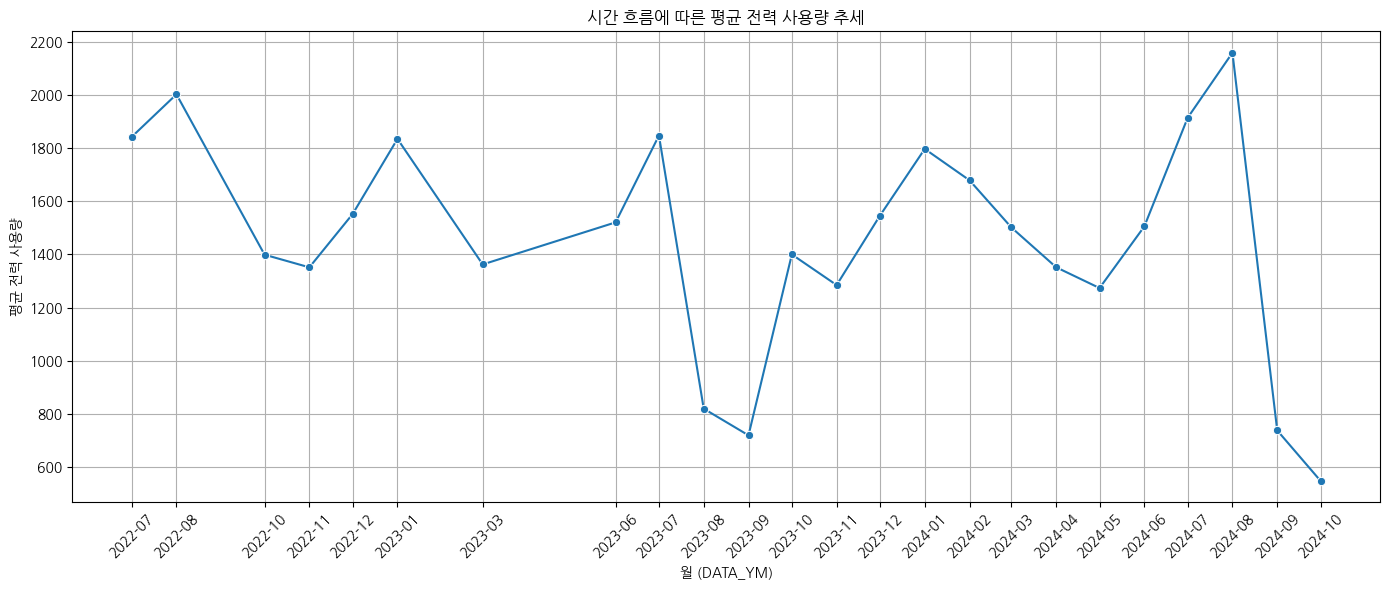

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# 월별 평균 전력 사용량 계산
monthly_usage = df.groupby('DATA_YM')['TOTAL_ELEC'].mean()

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_usage.index, y=monthly_usage.values, marker='o')

# X축에 모든 월 표시
plt.xticks(ticks=monthly_usage.index, labels=monthly_usage.index.strftime('%Y-%m'), rotation=45)

plt.title('시간 흐름에 따른 평균 전력 사용량 추세')
plt.xlabel('월 (DATA_YM)')
plt.ylabel('평균 전력 사용량')
plt.grid(True)
plt.tight_layout()
plt.show()


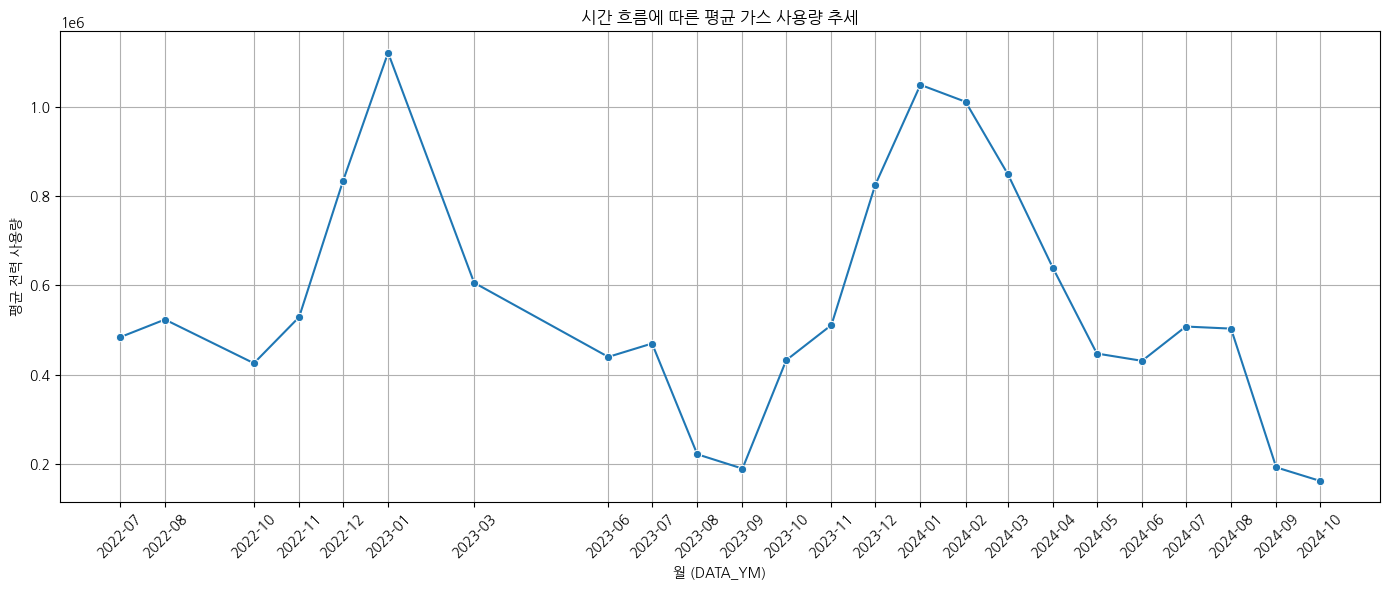

In [145]:

# 월별 평균 전력 사용량 계산
monthly_usage = df.groupby('DATA_YM')['TOTAL_GAS'].mean()

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_usage.index, y=monthly_usage.values, marker='o')

# X축에 모든 월 표시
plt.xticks(ticks=monthly_usage.index, labels=monthly_usage.index.strftime('%Y-%m'), rotation=45)

plt.title('시간 흐름에 따른 평균 가스 사용량 추세')
plt.xlabel('월 (DATA_YM)')
plt.ylabel('평균 전력 사용량')
plt.grid(True)
plt.tight_layout()
plt.show()


### 전기
✅ 주요 패턴:

여름 (7~8월): 전력 사용량 급증, 에어컨 등 냉방 수요 때문일 확률 큼.

가을 (9~10월): 급감 → 냉방도 난방도 거의 없는 계절이라 사용량 최소.

겨울 (12~2월): 다소 상승, 난방용 전기 수요로 해석 가능.

봄 (3~5월): 상대적으로 낮은 편. 전기 사용 수요가 많지 않은 계절.

전체 흐름: 여름 피크 - 가을 저점 - 겨울 중간 - 봄 저점 형태 반복.

### 가스
✅ 주요 패턴:
11월 ~ 3월 (겨울철) 피크

C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\3995804323.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')
C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\3995804323.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')


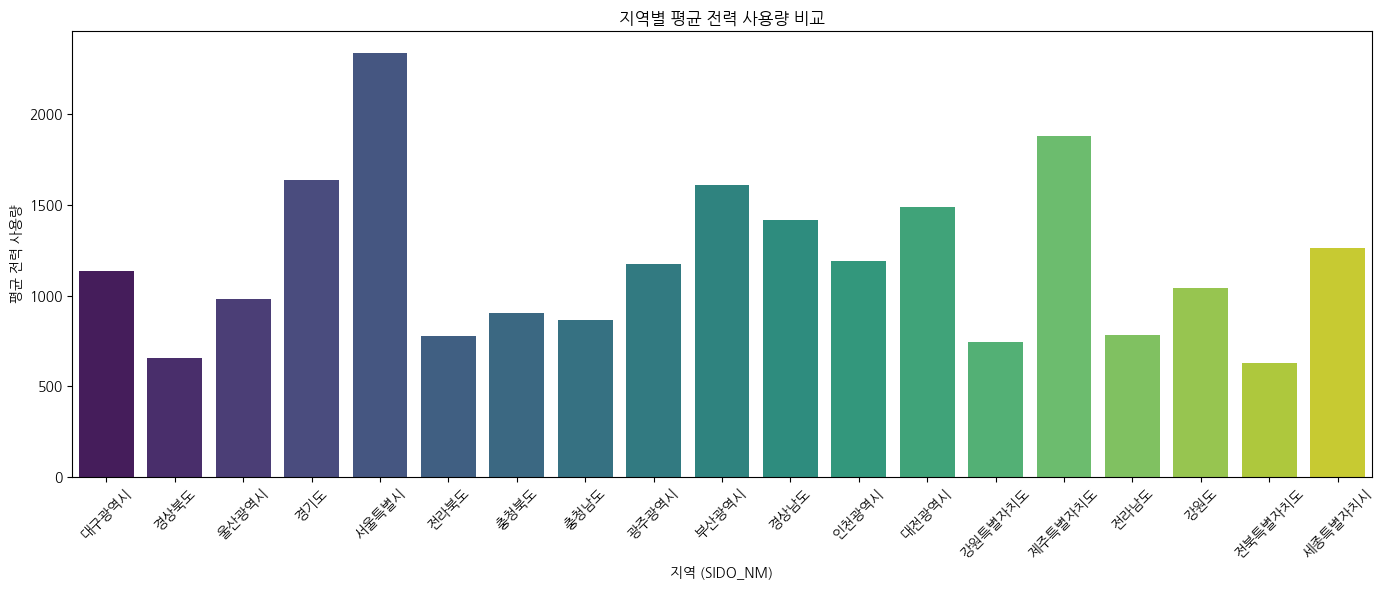

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일 설정
#sns.set_style('whitegrid')

plt.figure(figsize=(14, 6))

# 시각화
sns.barplot(data=df, x='SIDO_NM', y='TOTAL_ELEC', estimator='mean', ci=None, palette='viridis')

# 레이블 회전 및 제목
plt.xticks(rotation=45)
plt.title('지역별 평균 전력 사용량 비교')
plt.ylabel('평균 전력 사용량')
plt.xlabel('지역 (SIDO_NM)')

plt.tight_layout()
plt.show()


In [147]:
# 6. 계절변수 생성
# 월 추출
df['MONTH'] = df['DATA_YM'].dt.month

# 계절 변수 만들기
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['SEASON'] = df['MONTH'].apply(get_season)

C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\4015334387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MONTH'] = df['DATA_YM'].dt.month
C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\4015334387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEASON'] = df['MONTH'].apply(get_season)


In [148]:
# pandas의 get_dummies 사용
season_ohe = pd.get_dummies(df['SEASON'], prefix='SEASON')

# 기존 df에 붙이기
df = pd.concat([df, season_ohe], axis=1)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25344 entries, 0 to 26098
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATA_YM       25344 non-null  datetime64[ns]
 1   AREA_ID       25344 non-null  int64         
 2   AREA_NM       25344 non-null  object        
 3   DIST_CD       25344 non-null  object        
 4   DIST_NM       25344 non-null  object        
 5   TOTAL_BIDG    25344 non-null  float64       
 6   FAC_NEIGH_1   25344 non-null  float64       
 7   FAC_NEIGH_2   25344 non-null  float64       
 8   FAC_CULT_MTG  25344 non-null  float64       
 9   FAC_RELG      25344 non-null  float64       
 10  FAC_RETAIL    25344 non-null  float64       
 11  FAC_MEDI      25344 non-null  float64       
 12  FAC_YOSE      25344 non-null  float64       
 13  FAC_TRAIN     25344 non-null  float64       
 14  FAC_SPORT     25344 non-null  float64       
 15  FAC_STAY      25344 non-null  float64    

In [150]:
# 클러스터 변수 추가 위한 클러스터링
# 건물정보 클러스터링 ( 시간적인 요소 고려함 )
# 1. 로그변환 대상 변수 지정
log_vars = [
    'TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 'FAC_RELG',
    'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 'FAC_SPORT',
    'FAC_STAY', 'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS'
]

# 로그 변환 (log1p는 log(1+x)로 0도 안전하게 변환 가능)
df_log = df.copy()
df_log[log_vars] = df_log[log_vars].apply(lambda x: np.log1p(x))

# 2. Feature 선택 (로그변환된 것 + 계절 One-hot)
features_for_cluster = log_vars + ['SEASON_봄', 'SEASON_여름', 'SEASON_가을', 'SEASON_겨울']
X_cluster = df_log[features_for_cluster]

# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [151]:
# 4. KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=8561, n_init='auto')
df['CLUSTER'] = kmeans.fit_predict(X_scaled)

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


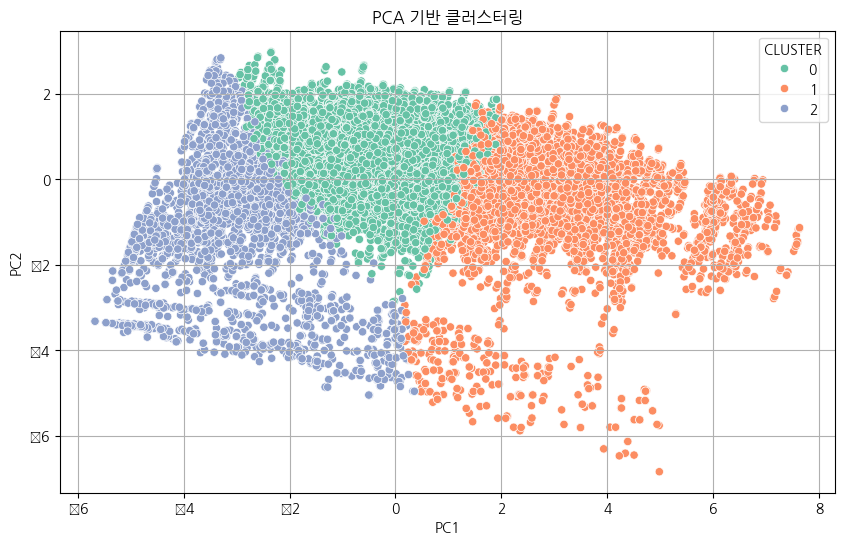

In [152]:
# 5. PCA 시각화
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='CLUSTER', palette='Set2')
plt.title("PCA 기반 클러스터링")
plt.grid(True)
plt.show()

In [ ]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette = silhouette_score(X_train, kmeans.labels_)
#print(f'Silhouette Score: {silhouette}')

In [153]:
df.groupby('CLUSTER')[['TOTAL_ELEC', 'TOTAL_GAS']].mean()

,TOTAL_ELEC,TOTAL_GAS
CLUSTER,,
0,1372.929441,573908.930609
1,2040.111966,833259.701645
2,851.965227,200219.450385


In [154]:
df.groupby('CLUSTER')['SIDO_NM'].value_counts(normalize=True)

CLUSTER  SIDO_NM
0        서울특별시      0.252694
         경기도        0.223623
         부산광역시      0.089652
         인천광역시      0.056854
         경상북도       0.056583
         대구광역시      0.041404
         전라남도       0.039303
         광주광역시      0.035034
         충청남도       0.031036
         충청북도       0.029749
         경상남도       0.027648
         전라북도       0.027309
         대전광역시      0.026631
         울산광역시      0.023243
         전북특별자치도    0.019652
         강원특별자치도    0.012198
         강원도        0.005963
         제주특별자치도    0.001423
1        경기도        0.127475
         서울특별시      0.125647
         부산광역시      0.093512
         전라남도       0.090771
         경상남도       0.077977
         경상북도       0.074627
         충청남도       0.064727
         강원특별자치도    0.047365
         광주광역시      0.042796
         충청북도       0.039446
         인천광역시      0.037313
         대구광역시      0.033201
         전라북도       0.029242
         울산광역시      0.028328
         대전광역시      0.026348
         강원도        0.0260

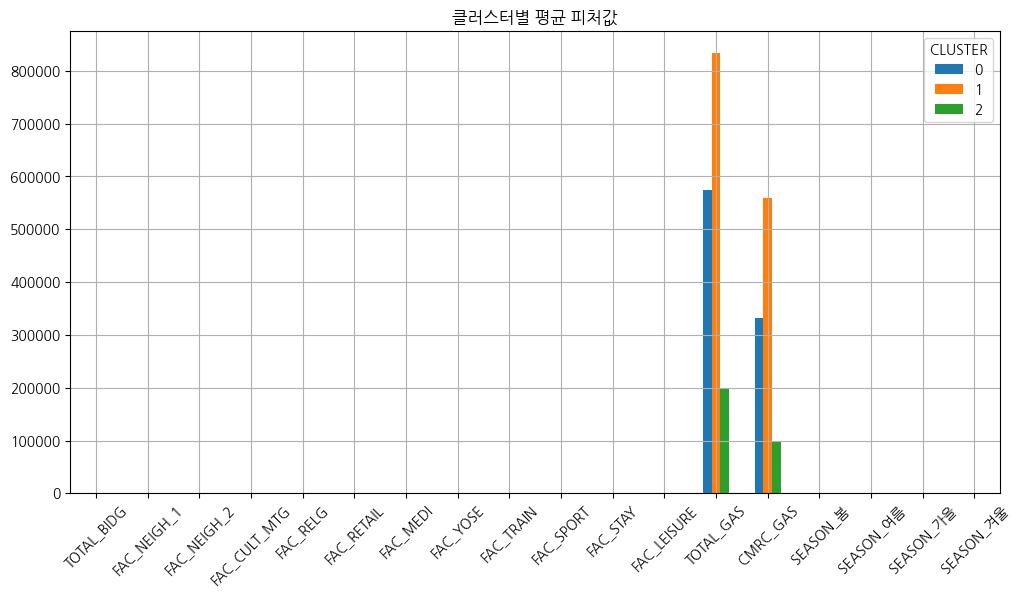

In [155]:
df.groupby('CLUSTER')[features_for_cluster].mean().T.plot(kind='bar', figsize=(12,6))
plt.title("클러스터별 평균 피처값")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [156]:
# + 지역 정보 (DIST_CD) 클러스터링
region_features = df.groupby('DIST_CD')[[
    'TOTAL_BIDG',          # 총 건물 수
    'FAC_NEIGH_1',         # 인근 시설 1
    'FAC_NEIGH_2',         # 인근 시설 2
    'FAC_CULT_MTG',        # 문화/집회
    'FAC_RELG',            # 종교
    'FAC_RETAIL',          # 소매
    'FAC_MEDI',            # 의료
    'FAC_YOSE',            # 요양
    'FAC_TRAIN',           # 학원
    'FAC_SPORT',           # 스포츠
    'FAC_STAY',            # 숙박
    'FAC_LEISURE',         # 여가
    'TOTAL_GAS',           # 총 가스
    'CMRC_GAS'             # 상업용 가스
]].mean().reset_index()

In [157]:
region_features.describe()

,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,FAC_TRAIN,FAC_SPORT,FAC_STAY,FAC_LEISURE,TOTAL_GAS,CMRC_GAS
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,2.710000e+02,2.710000e+02
mean,225.263829,63.486077,46.638784,0.372790,0.640528,1.202568,0.593049,0.794381,0.016905,0.158421,7.015038,2.360370,3.579250e+05,2.316405e+05
std,144.624361,53.476197,29.165915,0.557281,0.765057,1.486206,0.560069,0.898594,0.077241,0.304838,7.603928,3.119710,4.181222e+05,2.617543e+05
min,16.761905,2.188172,2.261905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,116.640603,24.182984,25.304924,0.000000,0.142136,0.406008,0.086132,0.224009,0.000000,0.000000,1.865719,0.427052,6.630500e+04,4.240891e+04
50%,184.958904,47.132867,42.609929,0.168224,0.439024,0.869565,0.500000,0.533333,0.000000,0.000000,4.827586,1.308824,2.514018e+05,1.676166e+05
75%,305.414130,89.812652,60.329745,0.517880,0.856189,1.561422,0.864745,1.000000,0.000000,0.178703,9.136364,3.206856,5.063448e+05,3.451451e+05
max,912.375000,315.772727,147.636364,3.384615,6.000000,14.000000,2.571429,7.000000,0.869565,2.000000,58.820513,21.938462,3.603628e+06,2.453422e+06


In [158]:
# 로그 변환 (0 이하의 값 처리)
log_transform_columns = [
    'TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 
    'FAC_RELG', 'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 
    'FAC_TRAIN', 'FAC_SPORT', 'FAC_STAY', 'FAC_LEISURE', 
    'TOTAL_GAS', 'CMRC_GAS'
]

# 로그 변환 적용
for col in log_transform_columns:
    region_features[col] = np.log1p(region_features[col])  # log(x + 1)

In [159]:
# bool 타입을 0과 1로 변환
region_features = region_features.applymap(lambda x: 1 if isinstance(x, bool) else x)
region_features = region_features.applymap(lambda x: 0 if isinstance(x, bool) else x)

# 스케일링
scaler = StandardScaler()
scaled_region_features = region_features.copy()

# 스케일링을 숫자형 데이터에만 적용 (bool을 제외한 열)
scaled_region_features[['TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 
                         'FAC_RELG', 'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 
                         'FAC_SPORT', 'FAC_STAY', 'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS']] = scaler.fit_transform(
    region_features[['TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 
                     'FAC_RELG', 'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 
                     'FAC_SPORT', 'FAC_STAY', 'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS']])

# 결과 출력
print(scaled_region_features.head())

  DIST_CD  TOTAL_BIDG  FAC_NEIGH_1  FAC_NEIGH_2  FAC_CULT_MTG  FAC_RELG  \
0   11110    0.053451     0.237013     0.956287      1.984444  0.208776   
1   11140    0.300503     0.593673     0.812630     -0.017826  0.158961   
2   11170   -0.691416    -0.419714    -0.121820     -0.531829 -0.007870   
3   11200   -1.207347    -1.174821    -1.010307     -0.825358 -0.567142   
4   11215   -0.123052    -0.523475     0.242233     -0.403360 -0.808181   

   FAC_RETAIL  FAC_MEDI  FAC_YOSE  FAC_TRAIN  FAC_SPORT  FAC_STAY  \
0   -0.583211 -0.602018 -0.702641  -0.238229  -0.425539  0.096965   
1    2.321940 -0.845068 -0.559507   0.383165  -0.091488  0.316155   
2    0.630204 -0.992004 -1.013209  -0.238229  -0.596496 -1.415369   
3   -0.207857 -0.685160 -1.284450  -0.238229  -0.596496 -0.137305   
4   -0.664809 -0.486466 -0.780096  -0.238229   0.081229 -1.144585   

   FAC_LEISURE  TOTAL_GAS  CMRC_GAS  
0    -0.225402   0.741970  0.627655  
1    -0.416427   0.901271  0.911005  
2    -1.190561   0.6

C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\2838965123.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  region_features = region_features.applymap(lambda x: 1 if isinstance(x, bool) else x)
C:\Users\dlwng\AppData\Local\Temp\ipykernel_15896\2838965123.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  region_features = region_features.applymap(lambda x: 0 if isinstance(x, bool) else x)


In [160]:
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_region_features['CLUSTER'] = kmeans.fit_predict(scaled_region_features)

C:\Users\dlwng\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


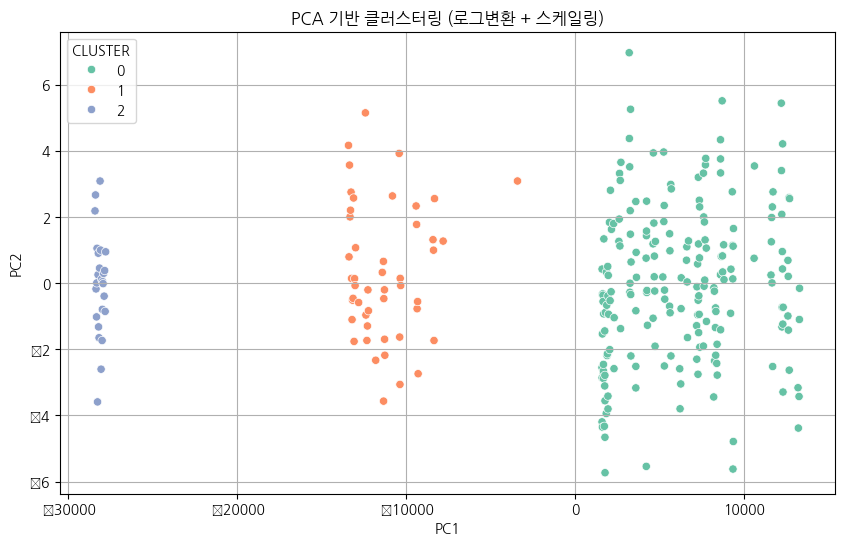

In [161]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_region_features)

scaled_region_features['PC1'] = pca_result[:, 0]
scaled_region_features['PC2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_region_features, x='PC1', y='PC2', hue='CLUSTER', palette='Set2')
plt.title("PCA 기반 클러스터링 (로그변환 + 스케일링)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
silhouette = silhouette_score(X_train, kmeans.labels_)
print(f'Silhouette Score: {silhouette}')

In [82]:
# 클러스터링 결과 컬럼명 변경
region_features_log = scaled_region_features.rename(columns={
    'CLUSTER': 'CLUSTER_REG',
    'PC1': 'PC1_REG',
    'PC2': 'PC2_REG'
})

# 병합
df = df.merge(region_features_log[['DIST_CD', 'CLUSTER_REG', 'PC1_REG', 'PC2_REG']],
              on='DIST_CD', how='left')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25344 entries, 0 to 25343
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATA_YM       25344 non-null  datetime64[ns]
 1   AREA_ID       25344 non-null  int64         
 2   AREA_NM       25344 non-null  object        
 3   DIST_CD       25344 non-null  object        
 4   DIST_NM       25344 non-null  object        
 5   TOTAL_BIDG    25344 non-null  float64       
 6   FAC_NEIGH_1   25344 non-null  float64       
 7   FAC_NEIGH_2   25344 non-null  float64       
 8   FAC_CULT_MTG  25344 non-null  float64       
 9   FAC_RELG      25344 non-null  float64       
 10  FAC_RETAIL    25344 non-null  float64       
 11  FAC_MEDI      25344 non-null  float64       
 12  FAC_YOSE      25344 non-null  float64       
 13  FAC_TRAIN     25344 non-null  float64       
 14  FAC_SPORT     25344 non-null  float64       
 15  FAC_STAY      25344 non-null  float6

In [84]:
df.describe()

,DATA_YM,AREA_ID,TOTAL_BIDG,FAC_NEIGH_1,FAC_NEIGH_2,FAC_CULT_MTG,FAC_RELG,FAC_RETAIL,FAC_MEDI,FAC_YOSE,...,TOTAL_GAS,CMRC_GAS,TOTAL_ELEC,MONTH,CLUSTER,PC1,PC2,CLUSTER_REG,PC1_REG,PC2_REG
count,25344,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,25344.000000,...,2.534400e+04,2.534400e+04,25344.000000,25344.000000,25344.000000,2.534400e+04,2.534400e+04,25344.000000,25344.000000,25344.000000
mean,2023-08-22 13:10:34.090908928,9740.560646,178.445668,44.198351,42.601010,0.289654,0.494634,1.087240,0.574021,0.580414,...,5.818119e+05,3.542066e+05,1463.125280,6.581676,0.523082,-5.551115e-17,6.055762e-17,0.699692,-6436.713373,-0.073345
min,2022-07-01 00:00:00,9138.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,-6.732756e+00,-8.672828e+00,0.000000,-28427.940911,-6.851937
25%,2023-01-01 00:00:00,9438.000000,51.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.075075e+04,4.096750e+04,368.330250,3.000000,0.000000,-1.371527e+00,-5.994836e-01,0.000000,-13247.940995,-0.905388
50%,2023-09-01 00:00:00,9734.000000,116.000000,19.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.529060e+05,1.647025e+05,823.349500,7.000000,0.000000,-7.823165e-02,2.507364e-01,0.000000,1579.058874,0.082836
75%,2024-04-01 00:00:00,10040.000000,245.000000,51.000000,59.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,6.611380e+05,4.118398e+05,1774.683250,10.000000,1.000000,1.355332e+00,9.537905e-01,1.000000,4692.059027,1.165570
max,2024-10-01 00:00:00,10376.000000,1530.000000,553.000000,872.000000,18.000000,15.000000,67.000000,7.000000,9.000000,...,2.125008e+07,1.953260e+07,27171.719000,12.000000,2.000000,7.528833e+00,3.890479e+00,2.000000,13262.059053,5.713741
std,NaN,352.207922,188.527093,66.751244,51.046922,0.851306,0.945696,2.475609,1.047036,1.079050,...,1.021517e+06,6.604911e+05,2058.041786,3.477999,0.687958,2.278678e+00,1.470234e+00,0.801917,13620.693769,1.919409


In [86]:
train[train['TOTAL_ELEC']==0].count()

DATA_YM         494
AREA_ID         494
AREA_NM         494
DIST_CD         494
DIST_NM         494
TOTAL_BIDG      494
FAC_NEIGH_1     494
FAC_NEIGH_2     494
FAC_CULT_MTG    494
FAC_RELG        494
FAC_RETAIL      494
FAC_MEDI        494
FAC_YOSE        494
FAC_TRAIN       494
FAC_SPORT       494
FAC_STAY        494
FAC_LEISURE     494
TOTAL_GAS       494
CMRC_GAS        494
TOTAL_ELEC      494
SIDO_CD         494
ADDR_CD         494
SIDO_NM         494
dtype: int64

# 모델링


In [87]:
# 타겟 설정
target = 'TOTAL_ELEC'

# 사용하지 않을 열
drop_cols = ['DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_NM', 'SIDO_CD', 'ADDR_CD', 'SIDO_NM', 'SEASON']

# 피처 설정
features = df.drop(columns=drop_cols + [target]).columns

In [90]:
# Train / Test 분리 (train_test_split 사용)
X = df[features]
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:

# 1. 클러스터링 변수들 (PC~ 및 CLUSTER) 제외한 변수들만 선택
columns_to_log = ['TOTAL_BIDG', 'FAC_NEIGH_1', 'FAC_NEIGH_2', 'FAC_CULT_MTG', 
                  'FAC_RELG', 'FAC_RETAIL', 'FAC_MEDI', 'FAC_YOSE', 'FAC_TRAIN', 
                  'FAC_SPORT', 'FAC_STAY', 'FAC_LEISURE', 'TOTAL_GAS', 'CMRC_GAS']

# 로그변환 (log1p 사용)
X_train_log = X_train.copy()
X_valid_log = X_valid.copy()

for col in columns_to_log:
    X_train_log[col] = np.log1p(X_train_log[col])
    X_valid_log[col] = np.log1p(X_valid_log[col])

In [92]:
# StandardScaler 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log[columns_to_log])
X_valid_scaled = scaler.transform(X_valid_log[columns_to_log])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns_to_log)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns_to_log)

In [93]:
# PC~, CLUSTER 계열 변수는 원래 데이터에서 그대로 붙여줌
cluster_features = ['CLUSTER', 'PC1', 'PC2', 'CLUSTER_REG', 'PC1_REG', 'PC2_REG']

X_train_scaled[cluster_features] = X_train[cluster_features].reset_index(drop=True)
X_valid_scaled[cluster_features] = X_valid[cluster_features].reset_index(drop=True)


In [95]:
# 5. 타겟 로그변환
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [96]:
# 6. 평가 함수
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    
    y_pred_train = np.expm1(model.predict(X_train))
    y_pred_valid = np.expm1(model.predict(X_valid))
    
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
    train_r2 = r2_score(y_train_actual, y_pred_train)
    train_mae = mean_absolute_error(y_train_actual, y_pred_train)

    valid_rmse = np.sqrt(mean_squared_error(y_valid_actual, y_pred_valid))
    valid_r2 = r2_score(y_valid_actual, y_pred_valid)
    valid_mae = mean_absolute_error(y_valid_actual, y_pred_valid)

    print(f"📌 [{name}]")
    print(f"Train - RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
    print(f"Valid - RMSE: {valid_rmse:.4f}, R²: {valid_r2:.4f}, MAE: {valid_mae:.4f}\n")


In [97]:
# 실제 y값 복원
y_train_actual = y_train
y_valid_actual = y_valid

In [98]:
# 7. 모델 정의
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)

In [99]:
# 8. 모델별 평가 실행
evaluate_model("XGBoost", xgb_model, X_train_scaled, y_train_log, X_valid_scaled, y_valid_log)
evaluate_model("RandomForest", rf_model, X_train_scaled, y_train_log, X_valid_scaled, y_valid_log)
evaluate_model("LightGBM", lgbm_model, X_train_scaled, y_train_log, X_valid_scaled, y_valid_log)

📌 [XGBoost]
Train - RMSE: 485.4117, R²: 0.9451, MAE: 215.6386
Valid - RMSE: 603.4576, R²: 0.9092, MAE: 264.4596

📌 [RandomForest]
Train - RMSE: 253.0989, R²: 0.9851, MAE: 91.9618
Valid - RMSE: 471.8315, R²: 0.9445, MAE: 214.7364

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2429
[LightGBM] [Info] Number of data points in the train set: 20275, number of used features: 20
[LightGBM] [Info] Start training from score 6.506804
📌 [LightGBM]
Train - RMSE: 787.9096, R²: 0.8553, MAE: 364.5794
Valid - RMSE: 814.7439, R²: 0.8345, MAE: 377.2137



<Figure size 1000x800 with 0 Axes>

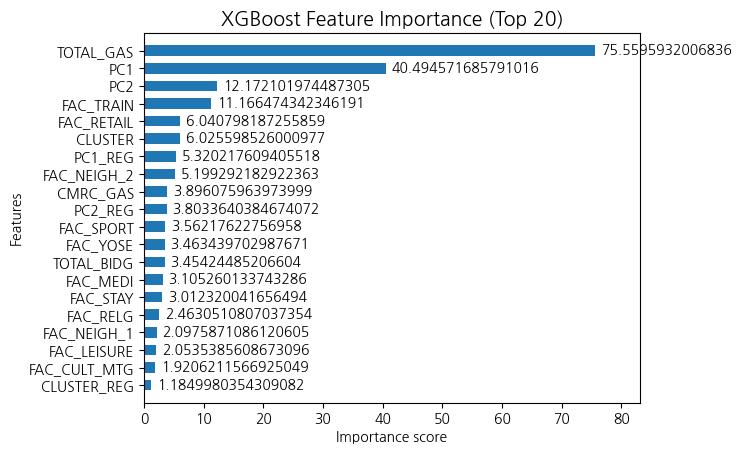

In [101]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# XGB중요도 시각화
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.6, grid=False)
plt.title('XGBoost Feature Importance (Top 20)', fontsize=14)
plt.show()

In [102]:
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

        Feature  Importance
12    TOTAL_GAS    0.385517
15          PC1    0.206610
16          PC2    0.062104
8     FAC_TRAIN    0.056973
5    FAC_RETAIL    0.030821
14      CLUSTER    0.030744
18      PC1_REG    0.027145
2   FAC_NEIGH_2    0.026528
13     CMRC_GAS    0.019878
19      PC2_REG    0.019405


### 추가예정

 체감온도 공식 (기온*풍속)

df['체감온도'] = df['기온']*df['풍속']

 불쾌지수 공식 ( 불쾌지수=0.72(기온+습구온도)+40.6 )

df['불쾌지수'] = 0.72(df['기온']+df['습구온도'])+40.6


에너지 사용패턴 기반 클러스터링
활용 변수: TOTAL_GAS, CMRC_GAS, TOTAL_ELEC, 기온, 체감온도, 불쾌지수

의미: 에너지 소비 성향에 따른 군집

파생 변수: CLUSTER_ENERGY, PC1_ENERGY, PC2_ENERGY
👉 “고효율군”, “낭비형군”, “온도민감군” 등

In [ ]:
# 추가예정

# 체감온도 공식 (기온*풍속)
#df['체감온도'] = df['기온']*df['풍속']

# 불쾌지수 공식 ( 불지수=0.72(기온+습구온도)+40.6 )
#df['불쾌지수'] = 0.81 * df['기온'] + 0.01 * df['습도'] * (0.99 * df['기온'] - 14.3) + 46.3